# **Define classes and functions in need**

In [1]:
import datetime
def get_time():
    current_time = datetime.datetime.now()
    adjusted_time = current_time + datetime.timedelta(hours=7)
    formatted_time = adjusted_time.strftime("%Hh%Mp - %d/%m/%Y")
    return formatted_time
    
print(f"Last save at: {get_time()}")

Last save at: 20h18p - 11/06/2025


In [2]:
!pip install pyheif pillow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 45.6 MB/s eta 0:00:00


In [3]:
!pip install torchvision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00


In [4]:
# transform data
# transform data
import torch
import torchvision.transforms.v2 as T
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
from PIL import Image
import os
import glob

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
import random

import pyheif
import shutil
import sys
from tqdm import tqdm
import logging
from contextlib import redirect_stdout

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as torch_models
from torchvision.transforms import InterpolationMode

import torch.optim as optim
import time
import functools

In [5]:
# CUSTOM IMAGE DATASET and process .HEIC images
def convert_heic_to_jpeg(heic_path, jpeg_path):
    try:
        heif_file = pyheif.read(heic_path)
        image = Image.frombytes(
            heif_file.mode, 
            heif_file.size, 
            heif_file.data, 
            "raw", 
            heif_file.mode, 
            heif_file.stride,
        )
        image.save(jpeg_path, format="JPEG")
    except Exception as e:
        print(f"\t🛑 Lỗi chuyển đổi .heic: {heic_path} — {e}")


def read_heic(img_path):
    jpeg_path = "heic2jpeg/" + img_path.split("/")[-1].replace(".HEIC", ".jpeg")
    convert_heic_to_jpeg(img_path, jpeg_path)
    image = Image.open(jpeg_path).convert("RGB")  # PIL.Image                
    return image
    
class custom_image_dataset(torch.utils.data.IterableDataset):
    def __init__(self, image_lists, transform=None, test=False):
        self.image_lists = image_lists
        self.transform = transform
        self.test = test

    def __read_image(self, img_path):
        try:
            if img_path.endswith(".HEIC"):
                image = read_heic(img_path)
                if image is not None:
                    print("--> Converted to JPEG")
                else:
                    print("--> Can't convert to JPEG")
            elif img_path.endswith(".md"):
                print("Found markdown")
                return None
            else:
                image = Image.open(img_path).convert("RGB")  # PIL.Image                
            truth = -1
            if not self.test:
                label_str = os.path.basename(img_path).split("_")[1]
                truth = torch.tensor(int(label_str))

            if self.transform:
                # print(f"Type: {type(self.transform)} ")
                if isinstance(self.transform, functools.partial):
                    image = self.transform()(image)  # Gọi transform với các tham số mặc định
                else:
                    image = self.transform(image)
            return image.float(), truth, img_path
        except Exception as e:
            print(f"\t**Error reading imgs: {e} - for: {img_path}")
            return None

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            iter_start = 0
            iter_end = len(self.image_lists)
        else:
            per_worker = int(len(self.image_lists) / float(worker_info.num_workers))
            worker_id = worker_info.id
            iter_start =  worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(self.image_lists))
        return iter(
            filter(lambda x : x is not None
                  , map(self.__read_image, self.image_lists[iter_start : iter_end] )
            )
        )

    def __len__(self):
        return len(self.image_lists)


In [6]:
# clear folder after using 
def clear_heics2jpegs():
    if not os.path.exists("heic2jpeg"):
        os.makedirs("heic2jpeg")
    else:
        shutil.rmtree("heic2jpeg")
        print("deleted old folder 'heic2jpeg'")
        os.makedirs("heic2jpeg")
        print("Created new 'heic2jpeg'")

clear_heics2jpegs()



In [7]:
# DEFINE CALLBACKS
# Ghi cả ra file và màn hình
class DualWriter:
    def __init__(self, file):
        self.file = file
        self.stdout = sys.__stdout__  # console thật

    def write(self, text):
        self.stdout.write(text)
        self.file.write(text)

    def flush(self):
        self.stdout.flush()
        self.file.flush()

class SaveBestModel:
    def __init__(self, save_path="best_model.pth", mode='min'):
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.save_path = save_path
        self.mode = mode

    def __call__(self, current_value, model):
        is_better = current_value < self.best_value if self.mode == 'min' else current_value > self.best_value
        if is_better:
            self.best_value = current_value
            torch.save(model.state_dict(), self.save_path)
            print(f"✅ Saved new best model ({self.mode} = {current_value:.4f})")

class EarlyStopping:
    def __init__(self, patience=5, mode='min'):
        self.patience = patience
        self.counter = 0
        self.best_value = float('inf') if mode == 'min' else -float('inf')
        self.early_stop = False
        self.mode = mode

    def __call__(self, current_value):
        is_better = current_value < self.best_value if self.mode == 'min' else current_value > self.best_value

        if is_better:
            self.best_value = current_value
            self.counter = 0
        else:
            self.counter += 1
            print(f"⚠️ No improvement. EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
    


In [8]:
# # function to process data: gray_100x100_norm
# # DO NOT CHANGE IN THE SAME DATA VERSION
# br = 0.65
# ct = 0.6
# transform = transforms.v2.Compose([
#     T.ToImage(),
#     T.GaussianBlur(kernel_size=(5,5), sigma=2.5),
#     T.ColorJitter(brightness=(br, br), contrast=(ct, ct)),
#     T.Grayscale(num_output_channels=1),
#     T.Resize((100, 100)),
#     T.ToDtype(torch.float32, scale=True),
#     T.Normalize(mean=[0.5], std=[0.5]), 
# ])

# # check how images are processed
# import matplotlib.pyplot as plt
# from torchvision.transforms.functional import to_pil_image

# # Lấy 9 ảnh đầu tiên
# temp = custom_image_dataset(train_list[:50], transform=transform)

# # Tạo figure
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid

# # Flatten axes để dễ duyệt
# axes = axes.flatten()
# it = iter(temp)
# for i in range(9):
#     img, truth, path = next(it)

#     # Hiển thị ảnh
#     axes[i].imshow(to_pil_image(img), cmap='gray')
#     axes[i].set_title(f"Label: {truth}")
#     axes[i].axis("off")  # Ẩn trục

# plt.tight_layout()
# plt.show()


# **Initialize pretrained model**

In [9]:
# what models to choose
models_list = dir(torch_models)
models_list = [m for m in models_list if "efficient" in m.lower()]
models_list


['EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'efficientnet',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s']

In [10]:
# init pretrained models and test_transform
weights = torch_models.EfficientNet_V2_L_Weights.DEFAULT
model = torch_models.efficientnet_v2_l(weights=weights)

test_transform = weights.transforms
print(test_transform)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 197MB/s]


functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=480, resize_size=480, interpolation=<InterpolationMode.BICUBIC: 'bicubic'>, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))


In [11]:
# find trainsize in "recipe" link
# find more info about model
for key in weights.meta.keys():
    if key == 'categories':
        continue
    print(f"{key}: {weights.meta[key]}")

min_size: (33, 33)
recipe: https://github.com/pytorch/vision/tree/main/references/classification#efficientnet-v2
num_params: 118515272
_metrics: {'ImageNet-1K': {'acc@1': 85.808, 'acc@5': 97.788}}
_ops: 56.08
_file_size: 454.573
_docs: These weights are ported from the original paper.


In [12]:
# create transform for training
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(384, interpolation=InterpolationMode.BILINEAR), # size lay tu docs
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),  # gần giống ta_wide
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     ),
# ])

gray_transform = T.Compose([
    T.Grayscale(3),
    T.Resize((480, 480)),
    # T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
    
])


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# **Prepare data**

In [13]:
# train and val 
data_dir = "/kaggle/input/handwritten-tl/digits_data"

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

print(os.path.exists(train_dir), os.path.exists(val_dir))

origin_train_list = glob.glob(train_dir + "/*/*")
origin_val_list = glob.glob(val_dir + "/*/*")

train_list = origin_train_list[:]
val_list = origin_val_list[:]

random.shuffle(train_list)
random.shuffle(val_list)

print(f"train: {len(train_list)}, val: {len(val_list)}")

True True
train: 5917, val: 1354


In [14]:
BATCH_SIZE = 128
num_workers = os.cpu_count()
print(f"Num workers: {num_workers}")

trainset = custom_image_dataset(train_list,transform=gray_transform, test=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=num_workers)

valset = custom_image_dataset(val_list, transform=gray_transform, test=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=num_workers)

classes = [i for i in range(10)]
classes

Num workers: 4


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# **Config**

In [15]:
# freeze parameters
for param in model.parameters():
    param.requires_grad = False
    
print(f"Before modding classifier layer: ", model.classifier)

# change the last layer:
model.classifier = nn.Sequential(
    # nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, len(classes))
)

print(f"\nAfter modding classifier layer: ", model.classifier)

Before modding classifier layer:  Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

After modding classifier layer:  Sequential(
  (0): Linear(in_features=1280, out_features=10, bias=True)
)


In [16]:
# check if parameters freezed
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Name: {name}, requires_grad: {param.requires_grad}")

Name: classifier.0.weight, requires_grad: True
Name: classifier.0.bias, requires_grad: True


In [17]:
# criterion and optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using deive: {device}")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using deive: cuda


In [18]:
# prepare log
if os.path.exists('train_log.txt'):
    os.remove('train_log.txt')
    print("Deleted old 'train_log'.")
    
# Ghi log ra log.txt
log_file = open("train_log.txt", "a")  # open log file

# define callbacks
dual_output = DualWriter(log_file)
save_best_model = SaveBestModel("best_model.pth", mode='min')
early_stopping = EarlyStopping(patience=5, mode='min')

# **TRAINING**

In [19]:
# start training (finetune)
start_time = time.time()
model.train()

with redirect_stdout(dual_output):
    for epoch in tqdm(range(30), desc="Epochs: "):  # loop over the dataset multiple times
        running_loss = 0.0
        print()
        epoch_start = time.time()
        for i, data in enumerate(trainloader, 0):
            inputs, labels, _ = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(inputs.device, labels.device, next(net.parameters()).device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1} loss: {epoch_loss:.4f} - time: {time.time() - epoch_start}s")

        # call callback
        save_best_model(epoch_loss, model)
        early_stopping(epoch_loss)
        
        if early_stopping.early_stop:
            print("⛔ Early stopping triggered.")
            break

    total_time = time.time() - start_time
    print(f'Finished Training in: {total_time//60:.0f}m {total_time%60:.0f}s\n')
    
print("🟢 Đã ra khỏi with, chỉ in ra console, không ghi file")
log_file.close()




Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   3%|▎         | 1/30 [05:58<2:53:30, 358.97s/it]

Epoch 1 loss: 2.0068 - time: 358.2568390369415s
✅ Saved new best model (min = 2.0068)



Epochs:   7%|▋         | 2/30 [12:08<2:50:24, 365.15s/it]

Epoch 2 loss: 1.5175 - time: 368.25560116767883s
✅ Saved new best model (min = 1.5175)



Epochs:  10%|█         | 3/30 [18:18<2:45:17, 367.32s/it]

Epoch 3 loss: 1.3076 - time: 368.6756010055542s
✅ Saved new best model (min = 1.3076)



Epochs:  13%|█▎        | 4/30 [24:28<2:39:40, 368.49s/it]

Epoch 4 loss: 1.1889 - time: 369.07832884788513s
✅ Saved new best model (min = 1.1889)



Epochs:  17%|█▋        | 5/30 [30:38<2:33:45, 369.00s/it]

Epoch 5 loss: 1.1191 - time: 368.7361698150635s
✅ Saved new best model (min = 1.1191)



Epochs:  20%|██        | 6/30 [36:47<2:27:38, 369.11s/it]

Epoch 6 loss: 1.0528 - time: 368.1588957309723s
✅ Saved new best model (min = 1.0528)



Epochs:  23%|██▎       | 7/30 [42:57<2:21:32, 369.22s/it]

Epoch 7 loss: 1.0045 - time: 368.2019727230072s
✅ Saved new best model (min = 1.0045)



Epochs:  27%|██▋       | 8/30 [49:06<2:15:22, 369.19s/it]

Epoch 8 loss: 0.9669 - time: 367.96572494506836s
✅ Saved new best model (min = 0.9669)



Epochs:  30%|███       | 9/30 [55:15<2:09:13, 369.21s/it]

Epoch 9 loss: 0.9360 - time: 368.0185842514038s
✅ Saved new best model (min = 0.9360)



Epochs:  33%|███▎      | 10/30 [1:01:24<2:02:58, 368.94s/it]

Epoch 10 loss: 0.9240 - time: 367.139319896698s
✅ Saved new best model (min = 0.9240)



Epochs:  37%|███▋      | 11/30 [1:07:32<1:56:46, 368.75s/it]

Epoch 11 loss: 0.8784 - time: 367.0990993976593s
✅ Saved new best model (min = 0.8784)



Epochs:  40%|████      | 12/30 [1:13:41<1:50:40, 368.94s/it]

Epoch 12 loss: 0.8752 - time: 368.2173762321472s
✅ Saved new best model (min = 0.8752)



Epochs:  43%|████▎     | 13/30 [1:19:51<1:44:35, 369.13s/it]

Epoch 13 loss: 0.8525 - time: 368.3713541030884s
✅ Saved new best model (min = 0.8525)



Epochs:  47%|████▋     | 14/30 [1:26:00<1:38:27, 369.22s/it]

Epoch 14 loss: 0.8269 - time: 368.201048374176s
✅ Saved new best model (min = 0.8269)



Epochs:  50%|█████     | 15/30 [1:32:09<1:32:17, 369.19s/it]

Epoch 15 loss: 0.8185 - time: 367.88751888275146s
✅ Saved new best model (min = 0.8185)



Epochs:  53%|█████▎    | 16/30 [1:38:18<1:26:06, 369.07s/it]

Epoch 16 loss: 0.8142 - time: 367.56725668907166s
✅ Saved new best model (min = 0.8142)



Epochs:  57%|█████▋    | 17/30 [1:44:27<1:19:57, 369.05s/it]

Epoch 17 loss: 0.7831 - time: 367.7571544647217s
✅ Saved new best model (min = 0.7831)



Epochs:  60%|██████    | 18/30 [1:50:36<1:13:47, 368.92s/it]

Epoch 18 loss: 0.7747 - time: 367.4310390949249s
✅ Saved new best model (min = 0.7747)



Epochs:  63%|██████▎   | 19/30 [1:56:44<1:07:36, 368.76s/it]

Epoch 19 loss: 0.7783 - time: 368.3785409927368s
⚠️ No improvement. EarlyStopping counter: 1/5



Epochs:  67%|██████▋   | 20/30 [2:02:53<1:01:27, 368.72s/it]

Epoch 20 loss: 0.7583 - time: 367.37457633018494s
✅ Saved new best model (min = 0.7583)



Epochs:  70%|███████   | 21/30 [2:09:01<55:18, 368.71s/it]  

Epoch 21 loss: 0.7647 - time: 368.6945204734802s
⚠️ No improvement. EarlyStopping counter: 1/5



Epochs:  73%|███████▎  | 22/30 [2:15:10<49:09, 368.66s/it]

Epoch 22 loss: 0.7370 - time: 367.3243350982666s
✅ Saved new best model (min = 0.7370)



Epochs:  77%|███████▋  | 23/30 [2:21:20<43:03, 369.11s/it]

Epoch 23 loss: 0.7281 - time: 368.9775171279907s
✅ Saved new best model (min = 0.7281)



Epochs:  80%|████████  | 24/30 [2:27:30<36:56, 369.35s/it]

Epoch 24 loss: 0.7263 - time: 368.6989142894745s
✅ Saved new best model (min = 0.7263)



Epochs:  83%|████████▎ | 25/30 [2:33:39<30:46, 369.26s/it]

Epoch 25 loss: 0.7125 - time: 367.78851342201233s
✅ Saved new best model (min = 0.7125)



Epochs:  87%|████████▋ | 26/30 [2:39:47<24:35, 368.94s/it]

Epoch 26 loss: 0.7159 - time: 368.19982504844666s
⚠️ No improvement. EarlyStopping counter: 1/5



Epochs:  90%|█████████ | 27/30 [2:45:56<18:26, 368.86s/it]

Epoch 27 loss: 0.6969 - time: 367.4166693687439s
✅ Saved new best model (min = 0.6969)



Epochs:  93%|█████████▎| 28/30 [2:52:03<12:16, 368.37s/it]

Epoch 28 loss: 0.7000 - time: 367.2278060913086s
⚠️ No improvement. EarlyStopping counter: 1/5



Epochs:  97%|█████████▋| 29/30 [2:58:10<06:07, 367.97s/it]

Epoch 29 loss: 0.6994 - time: 367.02419781684875s
⚠️ No improvement. EarlyStopping counter: 2/5



Epochs: 100%|██████████| 30/30 [3:04:18<00:00, 368.62s/it]

🟢 Đã ra khỏi with, chỉ in ra console, không ghi file


# **VALIDATE**

In [20]:
# load saved model in "best_model.pth", no need to turn on requires_grad
model = torch_models.efficientnet_v2_l(weights=None)
model.classifier = nn.Sequential(
    # nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, len(classes))
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))

model = model.to(device)
model.eval()

print("Start eval")

Start eval


In [21]:
# start validate
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels,_ = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on valset: {accuracy:.2f} %')


Accuracy on valset: 76.11 %


# **PREDICTS 2K IMAGES**

In [22]:
# clear folder
clear_heics2jpegs()

# prepare data
test_dir = "/kaggle/input/handwritten-test-cs114"
test_list = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
print(f"samples: {len(test_list)}")

testset = custom_image_dataset(test_list, transform=gray_transform, test=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE, num_workers=num_workers)

deleted old folder 'heic2jpeg'
Created new 'heic2jpeg'
samples: 2939


In [23]:
# start prediction
predict_txt = ""
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # save
        for path, pred in zip(paths, predicted):
            path = path.replace(test_dir, "").lstrip(os.sep)  # Strip test_dir and leading separator
            predict_txt += f"{path},{pred.item()}\n"

# Write to file in text mode
with open("/kaggle/working/predict_2k.txt", "w") as file:
    file.write(predict_txt)
print("Predictions saved in 'predict_2k.txt'")


--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Found markdown
Found markdown
--> Converted to JPEG
--> Converted to JPEG
Found markdown
Found markdown
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Found markdown
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
--> Converted to JPEG
Predictions saved in 'predict_2k.txt'


label (wrong truth cause this is test phase): -1
/kaggle/input/handwritten-test-cs114/389269258327f495063eeb7863aeb323  -.jpg


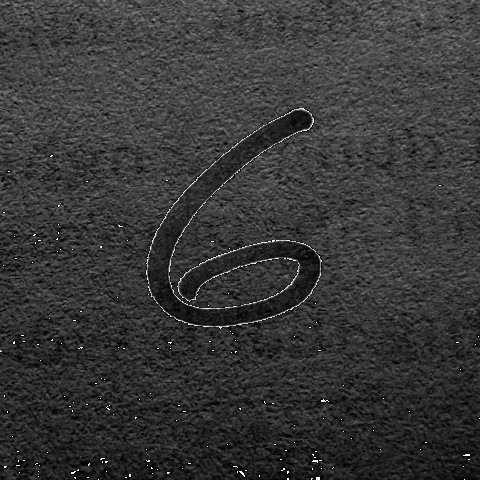

In [24]:
# show a processed test image
temp = custom_image_dataset(test_list[:10], transform=gray_transform, test=True)
it = iter(temp)
img, truth, path = next(it)

print(f"label (wrong truth cause this is test phase): {truth}")
print(path)

display(to_pil_image(img))

# **PREDICT 10K IMAGES**

In [25]:
# CLEAR folder
clear_heics2jpegs()

# prepare data
test_dir = "/kaggle/input/handwritten-test-10k"
test_list = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
print(f"samples: {len(test_list)}")

testset = custom_image_dataset(test_list, transform=test_transform, test=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE, num_workers=num_workers)

deleted old folder 'heic2jpeg'
Created new 'heic2jpeg'
samples: 9974


In [26]:
# start predicting
predict_txt = ""
with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # save
        for path, pred in zip(paths, predicted):
            path = path.replace(test_dir, "").lstrip(os.sep)  # Strip test_dir and leading separator
            predict_txt += f"{path},{pred.item()}\n"

# Write to file in text mode
with open("/kaggle/working/predict_10k.txt", "w") as file:
    file.write(predict_txt)
print("Predictions saved in 'predict_10k.txt'")



Predictions saved in 'predict_10k.txt'


label: -1
/kaggle/input/handwritten-test-10k/167144297687438af7bff077e768440c.jpg


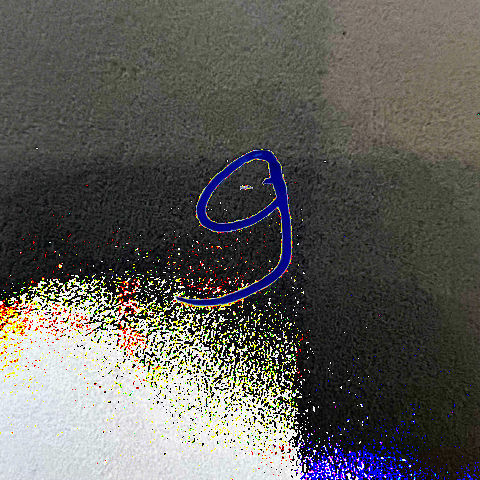

In [27]:
# show a processed test image
temp = custom_image_dataset(test_list[:10], transform=test_transform, test=True)
it = iter(temp)
img, truth, path = next(it)

print(f"label: {truth}")
print(path)

display(to_pil_image(img))

# **Save**

In [28]:
log_path = "train_log.txt"
with open(log_path, "a") as f:
    f.write("\n\n" + "="*60 + "\n")
    f.write("Training Summary\n")
    f.write("="*60 + "\n")
    f.write(f"Time: {total_time//60:.0f}m {total_time%60:.0f}s\n")
    f.write(f"Best Validation Accuracy: {accuracy:.4f}\n")
    f.write(f"\nOptimizer: {optimizer.__class__.__name__} - {optimizer.state_dict()['param_groups'][0]}\n")
    f.write(f"Loss Function: {criterion.__class__.__name__}\n")
    f.write("="*60 + "\n")
    f.write(f"Save on: {get_time()} \n\n\n")


# **TEST**

In [29]:
whats_new = """
- EfficientNet V2 L
- train and test share the same transform: gray_transform
- Remove dropout layer before classifier layer

** save: EfficientNetV2L_gray_480x480/no_dropout
"""